# Clustering Overview

This example notebook will demonstrate Howso Engine’s ability to calculate pairwise distances for the training cases. This capability is based on Howso Engine’s underlying instance-based learning platform. Distances can be used for a variety of use cases, in particular, for clustering algorithms, such as HDBSCAN. Howso Engine’s feature reduction capabilities will also be used to demonstrate how to eliminate features for clustering. 

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.cluster import HDBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score

from howso import engine
from howso.utilities import infer_feature_attributes

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

## Generate a simple dataset with noise

A 2-D blob is generated along with an extra noise column. The noise column is used to demonstrate feature reduction.


In [2]:
blobs = make_blobs(n_samples=100, n_features=2, centers=[(1,0), (1,5), (10,2)], random_state=0)
df = pd.DataFrame(blobs[0], columns=['x', 'y'])
df['target'] = blobs[1]

# Noise
noise = np.random.uniform(df['y'].min(), df['y'].max(), len(df))
df['noise'] = noise

## Build Howso Engine model

In [3]:
# Infer features using dataframe format
features = infer_feature_attributes(df)

# Specify Context and Action Features
action_features = ['target']
context_features = features.get_names(without=action_features)

# Create the Trainee
t = engine.Trainee(
    features=features,
    overwrite_existing=True
)

# Train
t.train(df)

# Targeted Analysis
t.analyze(context_features=context_features, action_features=action_features)

# Feature Reduction

In this example, since we have a target variable, we can inspect the feature contributions and feature mean decrease in accuracy to understand how important each feature is.

In [4]:
t.react_into_trainee(context_features=context_features, action_feature=action_features[0], contributions_robust = True, mda_robust=True)
robust_feature_contributions = t.get_prediction_stats(action_feature=action_features[0], robust=True, stats=['contribution', 'mda'])
robust_feature_contributions

,y,x,noise
contribution,0.467570,0.352685,0.047758
mda,0.160268,0.075414,-0.052382


We can see that the noise column not only contributes less to the prediction than the other variables, but it also contributes little to the accuracy. This is expected from the noise column and demonstrates how unimportant features can be highlighted with Howso Engine.

# Feature Removal

Unuseful features like the noise feature can reduce the quality of the clustering so we will remove them in this example. Howso Engine allows use to easily remove the features from the Trainee.

In [5]:
# Remove the noise feature
t.remove_feature('noise')

# update context_features
context_features.remove('noise')

# Reanalyze the remaining features
t.analyze(context_features=context_features, action_features=action_features)

## Get pairwise distances

By directly using Howso Engine's pairwise distances, we can take advantage of all the benefits of Howso Engine, including the ease of preprocessing and categorical variable handling.

In [6]:
# pairwise distances can be obtained with a single function call
x = t.get_distances()

In [7]:
x['distances']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,41.864334,0.748096,41.431622,44.479314,11.105700,6.171995,45.430224,35.539918,15.616050,...,8.209483,37.101505,32.423673,40.706490,4.507167,45.349930,45.693690,39.761540,35.583313,37.714472
1,41.864334,0.000000,42.246489,18.155301,17.755571,37.110841,41.502962,22.943650,54.014657,53.848535,...,34.806204,60.639617,59.497067,21.501969,42.147290,68.938693,26.464743,61.014750,54.956019,57.356300
2,0.748096,42.246489,0.000000,42.049880,45.084849,11.853300,5.600376,46.082147,36.199361,15.838633,...,8.277392,37.673489,32.946996,41.358702,3.875604,45.884584,46.373359,40.361128,36.230701,38.348043
3,41.431622,18.155301,42.049880,0.000000,3.301069,32.602511,43.694314,5.480771,40.500357,48.697972,...,37.058587,47.930096,48.246268,3.637828,43.575603,55.410075,8.480936,47.484635,41.596601,43.746775
4,44.479314,17.755571,45.084849,3.301069,0.000000,35.826425,46.549827,5.293211,43.442460,51.983035,...,39.849302,50.941145,51.393632,6.222322,46.495702,58.289297,9.003212,50.392190,44.554201,46.659300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45.349930,68.938693,45.884584,55.410075,58.289297,38.617173,51.482158,54.803957,15.015248,32.643244,...,51.214690,8.786445,12.962446,52.068660,49.717484,0.000000,51.931855,7.969933,14.008882,11.699764
96,45.693690,26.464743,46.373359,8.480936,9.003212,35.710091,48.829171,3.758124,37.541098,50.512323,...,42.535322,45.271960,46.584615,6.111047,48.441867,51.931855,0.000000,44.233737,38.707762,40.571915
97,39.761540,61.014750,40.361128,47.484635,50.392190,31.936729,45.931252,47.012077,7.045423,28.861846,...,44.913324,3.525386,9.263430,44.171389,44.234970,7.969933,44.233737,0.000000,6.059672,3.739875
98,35.583313,54.956019,36.230701,41.596601,44.554201,26.891194,41.707714,41.344855,1.190271,26.577429,...,40.065510,6.597164,9.808484,38.339506,40.088702,14.008882,38.707762,6.059672,0.000000,2.504442


# Cluster

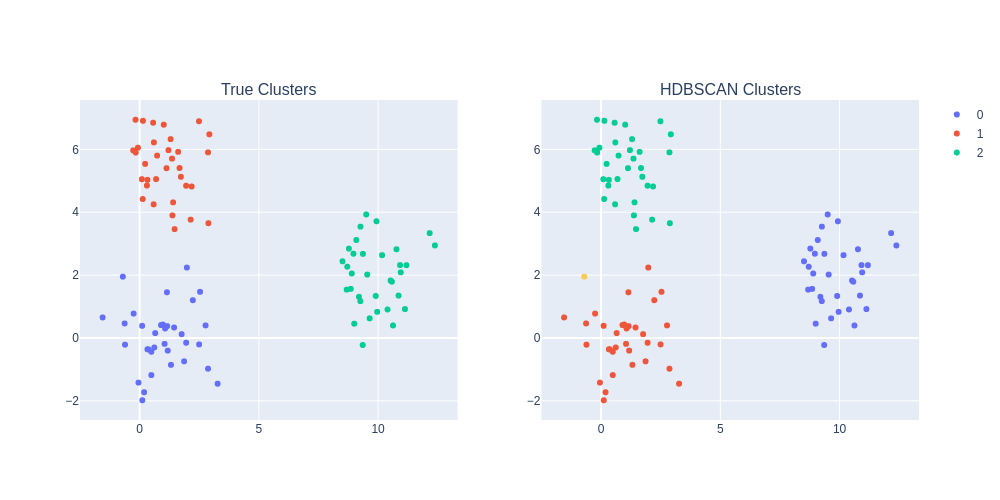

In [8]:
hdb = HDBSCAN(min_cluster_size = 15, min_samples=10, metric='precomputed').fit(x['distances'])
hdbscan_labels = hdb.labels_
df["hdbscan_labels"] = hdbscan_labels

fig = make_subplots(rows=1, cols=2, subplot_titles=["True Clusters", "HDBSCAN Clusters"])
for label, group in df.groupby("target"):
    fig.add_scatter(x=group.x, y=group.y, col=1, row=1, mode="markers", name=label)
for label, group in df.groupby("hdbscan_labels"):
    fig.add_scatter(
        x=group.x, y=group.y, col=2, row=1, mode="markers", name=label,
        marker_color=fig.layout["template"]["layout"]["colorway"][label],
        showlegend=False
    )
fig.update_layout(width=1000)
fig.show()

# Results

We calculate the performance of the clustering by measuring the similarity of the clusters compared to the original labels.

In [9]:
dist_contribution_acc = adjusted_rand_score(df['target'], hdbscan_labels)
print(f'clustering accuracy score: {dist_contribution_acc}')

clustering accuracy score: 0.9847653869591713
